# Experiment 1

We want to show that the differences do not come from numerical precision but from incoming zeros during back propagation

## Protocol:

* We initialize three networks:
    - One using the modified version of RelU as activation function
    - Two others using the original pytorch RelU as activation function
* We set the same initialization on all networks
* We train the three networks with the same batches
* We keep track of the $L^1$ norm of difference of weight matrices and bias vectors between the three networks 
* We keep track of the minimal absolute activation of the first hidden layer before application of ReLU.

In [12]:
import numpy as np
import numpy.random as npr
import argparse
import torch
import torch.nn as nn
from relu import ReLU6AlphaBeta
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt



## Double precision or not?
doublePrecision = False
doublePrecision = True

## To save results
bitsString = "32bits"
if doublePrecision:
    bitsString = "64bits"


if doublePrecision:
    torch.set_default_tensor_type(torch.DoubleTensor)
    torch.set_default_dtype(torch.float64)
else:
    torch.set_default_dtype(torch.float32)



## Load Data

In [13]:
## Initialize random seed
np.random.seed(1234)
torch.manual_seed(13)

## Load Training data

batch_size = 128

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


## Build Models

In [14]:
print('==> Building models..')
net1 = torch.nn.Sequential(
    torch.nn.Linear(28*28, 4000),
    ReLU6AlphaBeta(alpha=1, beta=0),
    torch.nn.Linear(4000, 256),
    ReLU6AlphaBeta(alpha=1, beta=1),
    torch.nn.Linear(256, 10))

net2 = torch.nn.Sequential(
    torch.nn.Linear(28*28,4000),
    torch.nn.ReLU6(),
    torch.nn.Linear(4000, 256),
    torch.nn.ReLU6(),
    torch.nn.Linear(256, 10))

net3 = torch.nn.Sequential(
    torch.nn.Linear(28*28,4000),
    torch.nn.ReLU6(),
    torch.nn.Linear(4000, 256),
    torch.nn.ReLU6(),
    torch.nn.Linear(256, 10))

if doublePrecision:
    net1 = net1.to(torch.float64)
    net2 = net2.to(torch.float64)
    net3 = net3.to(torch.float64)


print('==> Copying models initial parameters..')
params1 = net1.named_parameters()
params2 = net2.named_parameters()
params3 = net3.named_parameters()


dict_params2 = dict(params2)
dict_params3 = dict(params3)

for name, param in params1:
    if name in dict_params2:
        dict_params2[name].data.copy_(param.data)
    if name in dict_params3:
        dict_params3[name].data.copy_(param.data)

nets = [net1, net2, net3]

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device='cpu'
for net in nets:
    net.to(device)
    print(net)

optimizers = []
lr = 0.01 * (npr.random(1)[0]/5.0+1) 
for net in nets:
    optimizers.append(torch.optim.SGD(net.parameters(), lr=lr))
    
criterion = nn.CrossEntropyLoss()

==> Building models..
==> Copying models initial parameters..
Sequential(
  (0): Linear(in_features=784, out_features=4000, bias=True)
  (1): ReLU6AlphaBeta()
  (2): Linear(in_features=4000, out_features=256, bias=True)
  (3): ReLU6AlphaBeta()
  (4): Linear(in_features=256, out_features=10, bias=True)
)
Sequential(
  (0): Linear(in_features=784, out_features=4000, bias=True)
  (1): ReLU6()
  (2): Linear(in_features=4000, out_features=256, bias=True)
  (3): ReLU6()
  (4): Linear(in_features=256, out_features=10, bias=True)
)
Sequential(
  (0): Linear(in_features=784, out_features=4000, bias=True)
  (1): ReLU6()
  (2): Linear(in_features=4000, out_features=256, bias=True)
  (3): ReLU6()
  (4): Linear(in_features=256, out_features=10, bias=True)
)


## Training

In [15]:
for net in nets:
    net.train()

t = tqdm(iter(train_loader), leave=False, total=len(train_loader))
NstepMax = t.total 

## Difference between weights
difference12 = np.zeros(NstepMax)
difference23 = np.zeros(NstepMax)

## Activation of the first layer before application of relu
active11 = np.zeros(NstepMax)
active12 = np.zeros(NstepMax)


for batch_idx, (inputs, targets) in enumerate(t):
    ## Forward path for each network
    for i in range(len(nets)):
        optimizers[i].zero_grad()
        if doublePrecision:
            inView = inputs.view(-1, 28 * 28).to(torch.float64).to(device)
            outputs = nets[i](inView)
            loss = criterion(outputs, targets.to(device)).to(torch.float64)
        else:
            inView = inputs.view(-1, 28 * 28).to(torch.float32).to(device)
            outputs = nets[i](inView)
            loss = criterion(outputs, targets.to(device)).to(torch.float32)
        loss.backward()
        
        ## Keep track of activations
        active11[batch_idx] =  torch.min(torch.abs(net1[0](inView))).detach().numpy()
        active12[batch_idx] =  torch.min(torch.abs(net1[0](inView) - 6)).detach().numpy()
        #active2[batch_idx] =  torch.min(torch.abs(torch.cat( (net2[0](inView), net2[0](inView) - 6), 0) )).detach().numpy()
        #active3[batch_idx] =  torch.min(torch.abs(torch.cat( (net3[0](inView), net3[0](inView) - 6), 0)  )).detach().numpy()
    
    ## Keep track of weight differences
    sum1 = 0
    sum2 = 0
    for j in [0, 2, 4]:
        sum1 += torch.abs(net1[j].weight - net2[j].weight).sum()
        sum1 += torch.abs(net1[j].bias - net2[j].bias).sum()
        sum2 += torch.abs(net3[j].weight - net2[j].weight).sum()
        sum2 += torch.abs(net3[j].bias - net2[j].bias).sum()
                
    difference12[batch_idx] = sum1
    difference23[batch_idx] = sum2
    
    ## Perform an otptimization step for each network
    for i in range(len(nets)):
        optimizers[i].step()

### Plots wieght difference

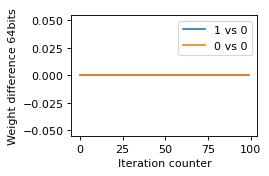

In [16]:


plt.figure(num=None, figsize=(3, 2), dpi=80, facecolor='w', edgecolor='k')
    
plt.plot(difference12[0:100], label = "1 vs 0")
plt.plot(difference23[0:100], label = "0 vs 0")
plt.xlabel("Iteration counter")
plt.ylabel("Weight difference "+bitsString)
plt.legend()

plt.savefig('diffRelu'+bitsString+'.pdf', bbox_inches='tight')

### Plot minimal magnitude before activation

No handles with labels found to put in legend.
No handles with labels found to put in legend.


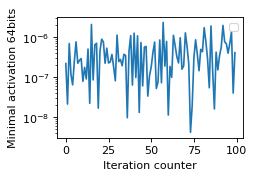

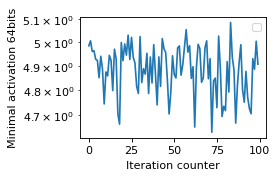

In [17]:
plt.figure(num=None, figsize=(3, 2), dpi=80, facecolor='w', edgecolor='k')
plt.plot(active11[0:100])
plt.yscale("log")
plt.xlabel("Iteration counter")
plt.ylabel("Minimal activation " + bitsString)
plt.legend()
plt.savefig('minActivation1'+bitsString+'.pdf', bbox_inches='tight')

plt.figure(num=None, figsize=(3, 2), dpi=80, facecolor='w', edgecolor='k')
plt.plot(active12[0:100])
plt.yscale("log")
plt.xlabel("Iteration counter")
plt.ylabel("Minimal activation " + bitsString)
plt.legend()
plt.savefig('minActivation2'+bitsString+'.pdf', bbox_inches='tight')

## Investigating the shape of the bifurcation zone
### Initialize networks in the exact same way and train in 32 bits

In [ ]:
## Initialize random seed
np.random.seed(1234)
torch.manual_seed(13)


torch.set_default_tensor_type(torch.FloatTensor)
torch.set_default_dtype(torch.float32)

## Load Training data

batch_size = 128

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


In [ ]:
print('==> Building models..')
net1 = torch.nn.Sequential(
    torch.nn.Linear(28*28, 2000),
    MyReLU(),
    torch.nn.Linear(2000, 128),
    MyReLU(),
    torch.nn.Linear(128, 10))

net2 = torch.nn.Sequential(
    torch.nn.Linear(28*28,2000),
    torch.nn.ReLU(),
    torch.nn.Linear(2000, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10))

net3 = torch.nn.Sequential(
    torch.nn.Linear(28*28,2000),
    torch.nn.ReLU(),
    torch.nn.Linear(2000, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10))



print('==> Copying models initial parameters..')
params1 = net1.named_parameters()
params2 = net2.named_parameters()
params3 = net3.named_parameters()


dict_params2 = dict(params2)
dict_params3 = dict(params3)

for name, param in params1:
    if name in dict_params2:
        dict_params2[name].data.copy_(param.data)
    if name in dict_params3:
        dict_params3[name].data.copy_(param.data)

nets = [net1, net2, net3]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
for net in nets:
    net.to(device)
    print(net)

optimizers = []
lr = 0.01 * (npr.random(1)[0]/5.0+1) 
for net in nets:
    optimizers.append(torch.optim.SGD(net.parameters(), lr=lr))
    
criterion = nn.CrossEntropyLoss()

### Retrain and stop at bifurcation

In [ ]:
for net in nets:
    net.train()

t = tqdm(iter(train_loader), leave=False, total=len(train_loader))
NstepMax = t.total 

## Difference between weights
difference12 = np.zeros(NstepMax)
difference23 = np.zeros(NstepMax)

## Activation of the first layer before application of relu
active1 = np.zeros(NstepMax)
active2 = np.zeros(NstepMax)
active3 = np.zeros(NstepMax)

for batch_idx, (inputs, targets) in enumerate(t):
    ## Forward path for each network
    for i in range(len(nets)):
        optimizers[i].zero_grad()
        inView = inputs.view(-1, 28 * 28).to(device)
        outputs = nets[i](inView)
        loss = criterion(outputs, targets)
        loss.backward()
        
        ## Keep track of activations
        active1[batch_idx] =  torch.min(torch.abs(net1[0](inView))).detach().numpy()
        active2[batch_idx] =  torch.min(torch.abs(net2[0](inView))).detach().numpy()
        active3[batch_idx] =  torch.min(torch.abs(net3[0](inView))).detach().numpy()
    
    ## Keep track of weight differences
    sum1 = 0
    sum2 = 0
    for j in [0, 2, 4]:
        sum1 += torch.abs(net1[j].weight - net2[j].weight).sum()
        sum1 += torch.abs(net1[j].bias - net2[j].bias).sum()
        sum2 += torch.abs(net3[j].weight - net2[j].weight).sum()
        sum2 += torch.abs(net3[j].bias - net2[j].bias).sum()
                
    difference12[batch_idx] = sum1
    difference23[batch_idx] = sum2
    
    if active1[batch_idx]==0:
        break
    
    ## Perform an otptimization step for each network
    for i in range(len(nets)):
        optimizers[i].step()

In [ ]:
## Print the problematic index 
tempWhere = np.where((net1[0](inView)).detach().numpy() == 0)
id1 = tempWhere[0][0]
id2 = tempWhere[1][0]
print(id1)
print(id2)


### Look in a randomly generated hyperplane

In [ ]:
import copy
torch.manual_seed(123)

perturb1 = torch.rand(net1[0].weight.shape)
perturb1 = perturb1 / torch.norm(perturb1)
perturb2 = torch.rand(net1[0].weight.shape)
perturb2 = perturb2 / torch.norm(perturb2)
net1bis = copy.deepcopy(net1)
weightSave = net1[0].weight.clone()

if doublePrecision:
    torch.set_default_tensor_type(torch.DoubleTensor)
    torch.set_default_dtype(torch.float64)
    inView = inView.to(torch.float64)
    perturb1 = perturb1.to(torch.float64)
    perturb2 = perturb2.to(torch.float64)
    weightSave = weightSave.to(torch.float64)
    net1 = net1.to(torch.float64)
    net1bis = net1bis.to(torch.float64)
    net2 = net2.to(torch.float64)
    net3 = net3.to(torch.float64)





N = 100

x = np.arange(-N,N) / N * 5 / 10**6 
y = np.arange(-N,N) / N * 5 / 10**6 
X, Y = np.meshgrid(x, y)
Z = np.zeros((x.size, y.size))
for i in range(x.size):
    for j in range(y.size):
        net1bis[0].weight = torch.nn.Parameter(weightSave +  x[i] * perturb1 + y[j] * perturb2)
        Z[i,j] = torch.abs(net1bis[0](inView)[id1,id2]).detach().numpy()


In [ ]:
levelsToPlot = 10**(np.arange(2,20) / 20 * 4 - 9)
if doublePrecision:
    levelsToPlot = 10**(np.arange(-4,20) / 20 * 4 - 9)

from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
plt.figure(num=None, figsize=(3, 2), dpi=80, facecolor='w', edgecolor='k')
plt.contourf(X, Y, Z, levels=levelsToPlot, locator=ticker.LogLocator(), cmap=cm.PuBu_r)


cbar = plt.colorbar()
cbar_ticks = 10.0**(np.arange(0,15)-9)
cbar.set_ticks(cbar_ticks)
plt.savefig('bifurcationZone'+bitsString+'.pdf', bbox_inches='tight')